# Imports

In [66]:
!git clone https://github.com/Nazar1997/sparse_vector.git

fatal: destination path 'sparse_vector' already exists and is not an empty directory.


In [67]:
!pip install torch_geometric

In [68]:
# Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm


# Graph dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold

import optuna

# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from sparse_vector import sparse_vector

# Data loading

In [69]:
!git clone https://github.com/MrARVO/GraphZ

fatal: destination path 'GraphZ' already exists and is not an empty directory.


In [70]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]

features = [i[:-4] for i in os.listdir('GraphZ/data/hg19_features/')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features if (i.split('_')[0] in groups)]

In [71]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'GraphZ/data/hg19_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"GraphZ/data/hg19_dna/{file}") for file in files])

In [72]:
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
ZDNA = load('GraphZ/data/hg19_zdna/ZDNA.pkl')

DNA_features = {feture: load(f'GraphZ/data/hg19_features/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1054 [00:00<?, ?it/s]

# Data selection

In [73]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale, RobustScaler

class GraphDataset(Dataset):
    def __init__(self, chroms, features, 
                 dna_source, features_source, 
                 labels, intervals, 
                 transform=None, pre_transform=None, pre_filter=None):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels = labels
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        
        self.ei = [[],[]]
        for i in range(3000-1):
            self.ei[0].append(i)
            self.ei[0].append(i+1)
            self.ei[1].append(i+1)
            self.ei[1].append(i)
        
        super().__init__(transform, pre_transform, pre_filter)

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, idx):
        interval = self.intervals[idx]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))
        
        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        X = torch.tensor(X, dtype=torch.float)

        #scaler = MinMaxScaler()
        #X = scaler.fit_transform(X)
        
        #scaler = StandardScaler()
        #X = scaler.fit_transform(X)
        
        #X = scale(X, with_std=True)
        
        #scaler = RobustScaler()
        #X_train_normalized = scaler.fit_transform(X_train)

        #batch_norm = nn.BatchNorm1d(X.shape[1])  # Применяется к количеству признаков
        #X= batch_norm(X)

        edge_index = torch.tensor(np.array(self.ei), dtype=torch.long)
        
        y = self.labels[interval[0]][interval[1]: interval[2]]
        y = torch.tensor(y, dtype=torch.int64)

        return Data(x=X, edge_index=edge_index, y=y)


In [74]:
width = 3000
block_size = 1500  # Размер блока для регионов с ZDNA
np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        mid_point = (interval[1] + interval[0]) // 2
        block_start = mid_point - block_size // 2
        block_end = mid_point + block_size // 2
        if ZDNA[chrm][interval[0]: interval[1]].any():
            #ints_in.append([chrm, interval[0], interval[1]])
            if block_start >= interval[0] and block_end <= interval[1]:
                ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]

100%|██████████| 5/5 [00:00<00:00, 6866.90it/s]


In [75]:
from sklearn.model_selection import KFold
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]
#KFold вместо StratifiedKFold UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
#warnings.warn(
skf = KFold(n_splits=5, shuffle=True, random_state=42)
train_inds, test_inds = next(skf.split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                   for i, elem in enumerate(equalized)]))
train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]
'''train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem 
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]'''

'train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"\n                                                                 for i, elem \n                                                                 in enumerate(equalized)]))\n\ntrain_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]'

In [76]:
train_dataset = GraphDataset(chrom_names, feature_names, 
                            DNA, DNA_features, 
                            ZDNA, train_intervals)

test_dataset = GraphDataset(chrom_names, feature_names, 
                           DNA, DNA_features, 
                           ZDNA, test_intervals)

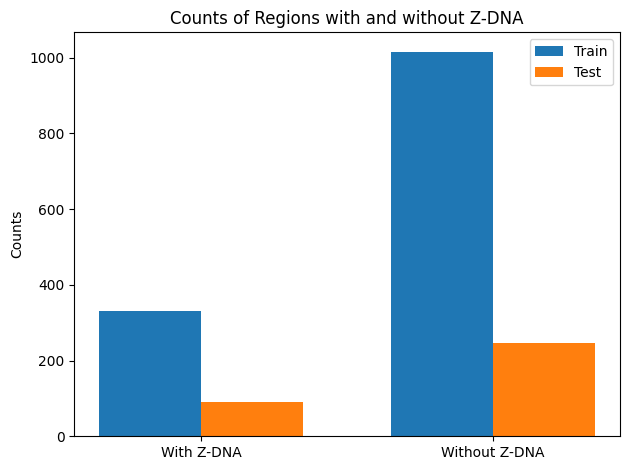

In [77]:
import matplotlib.pyplot as plt

# Счетчики регионов с Z-DNA и без него на обучающей выборке
train_regions_with_zdna = 0
train_regions_without_zdna = 0

# Счетчики регионов с Z-DNA и без него на тестовой выборке
test_regions_with_zdna = 0
test_regions_without_zdna = 0

# Подсчет количества регионов с Z-DNA и без него на обучающей выборке
for interval in train_intervals:
    chrom = interval[0]
    start = interval[1]
    end = interval[2]
    if ZDNA[chrom][start:end].any():
        train_regions_with_zdna += 1
    else:
        train_regions_without_zdna += 1

# Подсчет количества регионов с Z-DNA и без него на тестовой выборке
for interval in test_intervals:
    chrom = interval[0]
    start = interval[1]
    end = interval[2]
    if ZDNA[chrom][start:end].any():
        test_regions_with_zdna += 1
    else:
        test_regions_without_zdna += 1

# Создание графика
labels = ['With Z-DNA', 'Without Z-DNA']
train_counts = [train_regions_with_zdna, train_regions_without_zdna]
test_counts = [test_regions_with_zdna, test_regions_without_zdna]

x = range(len(labels))  # Создаем последовательность индексов для меток
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, train_counts, width, label='Train')  # Строим столбцы для обучающей выборки
rects2 = ax.bar([i + width for i in x], test_counts, width, label='Test')  # Строим столбцы для тестовой выборки

ax.set_ylabel('Counts')
ax.set_title('Counts of Regions with and without Z-DNA')
ax.set_xticks([i + width / 2 for i in x])  # Устанавливаем метки по середине каждого столбца
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [78]:
train_ratio_zdna = train_regions_with_zdna / (train_regions_with_zdna + train_regions_without_zdna)
train_ratio_no_zdna = train_regions_without_zdna / (train_regions_with_zdna + train_regions_without_zdna)

# Соотношение регионов с Z-DNA и без Z-DNA на тестовой выборке
test_ratio_zdna = test_regions_with_zdna / (test_regions_with_zdna + test_regions_without_zdna)
test_ratio_no_zdna = test_regions_without_zdna / (test_regions_with_zdna + test_regions_without_zdna)

print("Соотношение регионов с Z-DNA и без Z-DNA на обучающей выборке:")
print(f"С Z-DNA: {train_ratio_zdna:.2f}")
print(f"Без Z-DNA: {train_ratio_no_zdna:.2f}\n")

print("Соотношение регионов с Z-DNA и без Z-DNA на тестовой выборке:")
print(f"С Z-DNA: {test_ratio_zdna:.2f}")
print(f"Без Z-DNA: {test_ratio_no_zdna:.2f}")

Соотношение регионов с Z-DNA и без Z-DNA на обучающей выборке:
С Z-DNA: 0.25
Без Z-DNA: 0.75

Соотношение регионов с Z-DNA и без Z-DNA на тестовой выборке:
С Z-DNA: 0.27
Без Z-DNA: 0.73


In [79]:
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

loader_train = DataLoader(train_dataset, **params)
loader_test = DataLoader(test_dataset, **params)

# GNN model

In [80]:
class GraphZ(torch.nn.Module):
    def __init__(self):
        super(GraphZ, self).__init__()
        self.conv1 = GraphConv(1058, 500)
        #torch.nn.init.kaiming_normal_(torch.nn.Parameter(torch.Tensor(1058, 500)))  # Инициализация весов conv1 методом Xavier
        #nn.init.zeros_(layer.bias)
        self.conv2 = GraphConv(500, 250)
        #torch.nn.init.kaiming_uniform_(torch.nn.Parameter(torch.Tensor(500, 250)))
        #nn.init.zeros_(layer.bias)
        self.conv3 = GraphConv(250, 120)
        #torch.nn.init.kaiming_uniform_(torch.nn.Parameter(torch.Tensor(250, 120)))
        #nn.init.zeros_(layer.bias)
        self.conv4 = GraphConv(120, 2)
        #torch.nn.init.kaiming_uniform_(torch.nn.Parameter(torch.Tensor(120, 2)))
        #nn.init.zeros_(layer.bias)
        #self.conv5 = SAGEConv(60, 2)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.view(-1, 500)  # Изменение размерности тензора
        x = F.relu(x)
        x = F.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.conv4(x, edge_index)
        '''x = F.relu(x)
        x = F.dropout(x)
        x = self.conv5(x, edge_index)'''

        return F.log_softmax(x, dim=1)

# Train and test

In [81]:
def loss_func(output, y_batch):
    class_weights = torch.tensor([0.25, 1], dtype=torch.float)
    class_weights = class_weights.to("cuda:0")
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)(output, y_batch)
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param)**2
    return criterion + 0.0005 * l2_reg
    #return torch.nn.CrossEntropyLoss()(output, y_batch) + model.l2_regularization()


def train_epoch(model, optimizer):
    roc_auc_log, f1_log, acc_log, loss_log = [], [], [], []
    model.train()
    
    for dt in loader_train:
        x, edge, y = dt.x.cuda(), dt.edge_index.cuda(), dt.y.cuda().long()
        optimizer.zero_grad()
        
        output = model(x, edge)
        pred = torch.argmax(output, dim=1)
        y_pred = nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten()
        
        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten())
        roc_auc_log.append(roc_auc)
        
        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))
        
        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())
        
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    
    return roc_auc_log, f1_log, acc_log, loss_log


def test(model):
    roc_auc_log, f1_log, acc_log, loss_log = [], [], [], []
    model.eval()
    
    means = []
    for dt in loader_test:
        x, edge, y = dt.x.cuda(), dt.edge_index.cuda(), dt.y.cuda().long()
        
        output = model(x, edge)
        means.append(y.sum().cpu() / (1.0 * y.shape[0]))
        pred = torch.argmax(output, dim=1)
        
        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten())
        roc_auc_log.append(roc_auc)
        
        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten()))
        
        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())
        
        loss = loss_func(output, y)
        loss = loss.item()
        loss_log.append(loss)
    
    return roc_auc_log, f1_log, acc_log, loss_log


def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
                np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


def train(model, opt, n_epochs):  
    train_auc_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], []
    val_auc_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], []
    
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_auc, train_f1, train_acc, train_loss = train_epoch(model, opt)
        val_auc, val_f1, val_acc, val_loss = test(model)
                
        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)
        
        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))
        
        
        clear_output()
        plot_history(train_auc_log, val_auc_log, 'Auc', len(train_loss))
        plot_history(train_f1_log, val_f1_log, 'F1', len(train_loss))
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))
            
    
    print("Final ROC-AUC = {:.4}%".format(val_auc_log[-1]*100))
    print("Final F1-score = {:.3}%".format(val_f1_log[-1]*100))

    return val_auc_log, val_f1_log, val_acc_log, val_loss_log

In [82]:
torch.cuda.empty_cache()

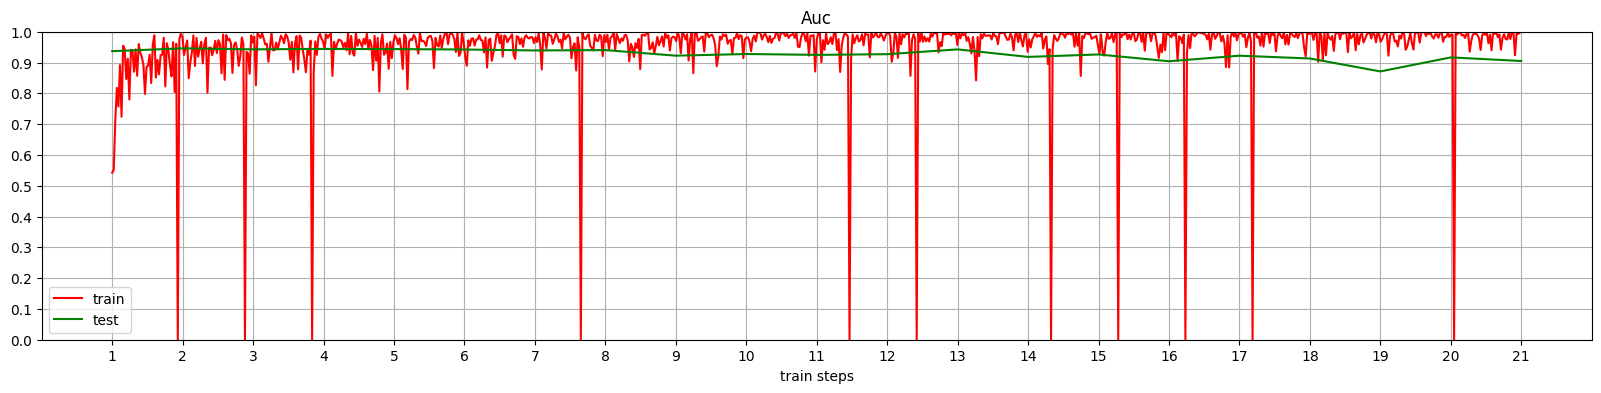

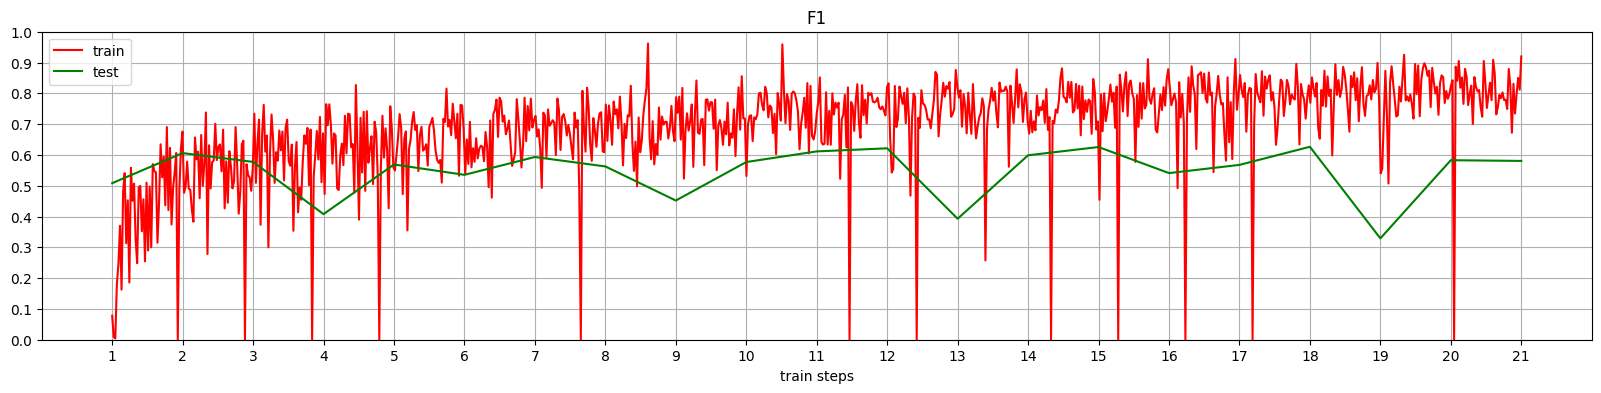

Epoch 21: ROC-AUC = 90.50%
Epoch 21: F1-score = 0.58
Final ROC-AUC = 90.5%
Final F1-score = 58.0%
CPU times: user 8min 11s, sys: 3min 17s, total: 11min 28s
Wall time: 23min 12s


In [83]:
%%time
model = GraphZ()
model = model.cuda()
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_f1_log, val_acc_log, val_loss_log = train(model, opt, 21)

In [84]:
print(val_f1_log)
print(val_auc_log)#leaky_relu

[0.5082966432324363, 0.6059681382628039, 0.5773428945665088, 0.4077640061289433, 0.5689731708481405, 0.5353751943607911, 0.5932220752838758, 0.5625817931225525, 0.45195726492516813, 0.5769093090723557, 0.611431717806079, 0.6214194258154614, 0.39280179294226464, 0.5988747180268057, 0.6256115312775941, 0.5409942229803909, 0.5676276516068864, 0.6264003513586003, 0.32904871286244614, 0.5828634838202469, 0.5804989162626119]
[0.9368730139499462, 0.9460298756265524, 0.9428188199666956, 0.9441683315984798, 0.943578574516395, 0.9422893940181538, 0.9391719721755105, 0.9403188561301031, 0.9222553393743141, 0.9276377616260937, 0.9248580501256419, 0.9270734798127062, 0.9426132030540614, 0.9182327748713255, 0.9262162124552222, 0.9041094510924957, 0.9221600746878849, 0.9131012474125235, 0.8711003786114325, 0.9166503934062188, 0.9049892210937471]


In [85]:
weights_dir = 'saved_weights'
weights_file = f'{weights_dir}/epoch_{7}.pt'
model.load_state_dict(torch.load(weights_file))

FileNotFoundError: [Errno 2] No such file or directory: 'saved_weights/epoch_7.pt'

In [ ]:
print(val_f1_log) #leaky_relu

In [ ]:
print(val_f1_log) #l2_reg

In [ ]:
print(val_f1_log)

In [ ]:
def objective(trial):
    # Оптимизируемые гиперпараметры
    in_feat = trial.suggest_int('in_feat', 300, 1000)
    out_feat = trial.suggest_int('out_feat', 100, 500)

    torch.cuda.empty_cache()
    model = GraphZ(in_feat,out_feat)
    model = model.cuda()

    opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)
    torch.cuda.empty_cache()
    val_auc_log, val_f1_log, val_acc_log, val_loss_log = train(model, opt, 5)
    # Возврат метрики, которую вы хотите оптимизировать
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

In [ ]:
#317, 'out_feat': 401
#787, 'out_feat': 280 445

In [ ]:
print(study.best_trial)

In [ ]:
best_params = study.best_params
print(best_params)

In [ ]:
#torch.save(model, 'gnn.pth')